In [82]:
#python deep_dream.py path_to_your_base_image.jpg prefix_for_results
#python deep_dream.py img/mypic.jpg results/dream

from __future__ import print_function

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

import tensorflow as tf

In [83]:
## load striped CAV, layer 9
import os
import cav
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)

In [84]:
layer_9_cav = this_cav.cavs[0]

In [85]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.

loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling
    #my_loss = loss

#loss = K.variable(0.)


# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        #print(loss.eval())
        x += step * grad_values
    return x


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""

Model loaded.


'Process:\n- Load the original image.\n- Define a number of processing scales (i.e. image shapes),\n    from smallest to largest.\n- Resize the original image to the smallest scale.\n- For every scale, starting with the smallest (i.e. current one):\n    - Run gradient ascent\n    - Upscale image to the next scale\n    - Reinject the detail that was lost at upscaling time\n- Stop when we are back to the original size.\nTo obtain the detail lost during upscaling, we simply\ntake the original image, shrink it down, upscale it,\nand compare the result to the (resized) original image.\n'

In [5]:
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname=result_prefix + '.png')

Processing image shape (152, 152)
..Loss value at 0 : 0.0
..Loss value at 1 : 0.0
..Loss value at 2 : 0.0
..Loss value at 3 : 0.0
..Loss value at 4 : 0.0
..Loss value at 5 : 0.0
..Loss value at 6 : 0.0
..Loss value at 7 : 0.0
..Loss value at 8 : 0.0
..Loss value at 9 : 0.0
..Loss value at 10 : 0.0
..Loss value at 11 : 0.0
..Loss value at 12 : 0.0
..Loss value at 13 : 0.0
..Loss value at 14 : 0.0
..Loss value at 15 : 0.0
..Loss value at 16 : 0.0
..Loss value at 17 : 0.0
..Loss value at 18 : 0.0
..Loss value at 19 : 0.0
Processing image shape (213, 213)
..Loss value at 0 : 0.010143651
..Loss value at 1 : 0.017692504
..Loss value at 2 : 0.039734017
..Loss value at 3 : 0.14368212
..Loss value at 4 : 0.19124295
..Loss value at 5 : 0.29235622
..Loss value at 6 : 0.37756634
..Loss value at 7 : 0.3951019
..Loss value at 8 : 0.39721248
..Loss value at 9 : 0.42917413
..Loss value at 10 : 0.590187
..Loss value at 11 : 0.57098824
..Loss value at 12 : 0.6254408
..Loss value at 13 : 0.8503788
..Loss

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:110: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [86]:
from keras.preprocessing import image
img_path = '/home/tyler/Desktop/tcav_on_azure/results/test.png'
img = image.load_img(img_path, target_size=(299, 299))

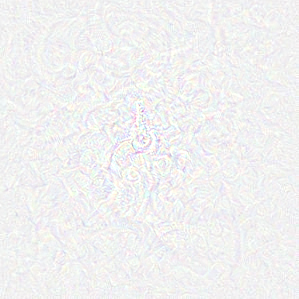

In [87]:
img

In [12]:
#outs = fetch_loss_and_grads([x])
grads = K.gradients(loss, dream)[0]


In [13]:
grads.eval(session=sess)

NameError: name 'sess' is not defined

In [80]:
loss

<tf.Tensor 'add_7:0' shape=() dtype=float32>

In [60]:
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [71]:
loss

<tf.Tensor 'add_7:0' shape=() dtype=float32>

In [72]:
K.sum(K.square(x[:, :, 2: -2, 2: -2]))

<tf.Tensor 'Sum_9:0' shape=() dtype=float32>

In [73]:
K.square(x[:, :, 2: -2, 2: -2])

<tf.Tensor 'Square_13:0' shape=(?, ?, ?, 2044) dtype=float32>

In [74]:
x[:, :, 2: -2, 2: -2]

<tf.Tensor 'strided_slice_14:0' shape=(?, ?, ?, 2044) dtype=float32>

In [14]:
sess = K.get_session()

loss.eval(session=sess)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,?,?,3]
	 [[node input_1 (defined at /data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517) ]]

Caused by op 'input_1', defined at:
  File "/data/anaconda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-edbc649a97a3>", line 39, in <module>
    include_top=False)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/applications/__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/applications/inception_v3.py", line 11, in InceptionV3
    return inception_v3.InceptionV3(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras_applications/inception_v3.py", line 157, in InceptionV3
    img_input = layers.Input(shape=input_shape)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5791, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,?,?,3]
	 [[node input_1 (defined at /data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517) ]]


In [30]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 5  # Number of ascent steps per scale
max_loss = 10

base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_white/img2.jpg'
result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

settings = {
    'features': {
        'mixed9': 10
    },}

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname=result_prefix + '.png')

Processing image shape (108, 108)
..Loss value at 0 : 0.0
..Loss value at 1 : 0.0
..Loss value at 2 : 0.0
..Loss value at 3 : 0.0
..Loss value at 4 : 0.0
Processing image shape (152, 152)
..Loss value at 0 : 0.0
..Loss value at 1 : 0.0
..Loss value at 2 : 0.0
..Loss value at 3 : 0.0
..Loss value at 4 : 0.0
Processing image shape (213, 213)
..Loss value at 0 : 0.008940544
..Loss value at 1 : 0.029604401
..Loss value at 2 : 0.049041513
..Loss value at 3 : 0.09826813
..Loss value at 4 : 0.1263795
Processing image shape (299, 299)
..Loss value at 0 : 0.3382423
..Loss value at 1 : 0.31407443
..Loss value at 2 : 0.36873823
..Loss value at 3 : 0.5006062
..Loss value at 4 : 0.5764508


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:110: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [127]:
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 5  # Number of ascent steps per scale
max_loss = 10

base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_white/img2.jpg'
result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

settings = {
    'features': {
        'mixed9': 10
    },}

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [31]:
real_img = image.array_to_img(img.reshape(299,299,3),scale=True)

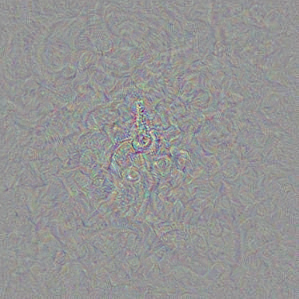

In [32]:
real_img

In [130]:
layer_9_acts.shape

(1, 2, 2, 2048)

In [133]:
original_img.shape

(1, 299, 299, 3)

In [141]:
x_img = shrunk_original_img

loss = None
loss = K.variable(0.)

layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: original_img})

flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

'''
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling
'''

"\nfor layer_name in settings['features']:\n    # Add the L2 norm of the features of a layer to the loss.\n    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'\n    coeff = settings['features'][layer_name]\n    x = layer_dict[layer_name].output\n    # We avoid border artifacts by only involving non-border pixels in the loss.\n    scaling = K.prod(K.cast(K.shape(x), 'float32'))\n    if K.image_data_format() == 'channels_first':\n        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling\n    else:\n        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling\n"

In [139]:
model.input

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

In [122]:
model.input

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

In [125]:
#img.shape

In [33]:
loss.shape

TensorShape([])

In [43]:
dream = model.input

In [44]:
dream

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [36]:
grads = K.gradients(loss, dream)[0]

In [37]:
grads

<tf.Tensor 'gradients_2/conv2d_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>

In [42]:
loss

<tf.Tensor 'add_3:0' shape=() dtype=float32>

In [57]:
layer_9_acts = layer_dict[layer_name].output

In [58]:
layer_9_acts

<tf.Tensor 'mixed9/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [120]:
x

<tf.Tensor 'mixed9_2/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [61]:
sess.run(bottlenecks_tensors[bottleneck_name],
                         {self.ends['input']: examples})

NameError: name 'bottlenecks_tensors' is not defined

In [65]:
def get_bottleneck_tensors():
    """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
    graph = tf.get_default_graph()
    bn_endpoints = {}
    for op in graph.get_operations():
        # change this below string to change which layers are considered bottlenecks
        # use 'ConcatV2' for InceptionV3
        # use 'MaxPool' for VGG16 (for example)
        if 'ConcatV2' in op.type:
            name = op.name.split('/')[0]
            bn_endpoints[name] = op.outputs[0]

    return bn_endpoints

In [69]:
bottlenecks_tensors = get_bottleneck_tensors()
bottleneck_name = 'mixed9'

In [70]:
bottlenecks_tensors[bottleneck_name]

<tf.Tensor 'mixed9/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [78]:
example = x

In [91]:
#example

In [108]:
loss += 4

In [110]:
#loss

In [89]:
this.shape

(1, 8, 8, 2048)

In [73]:
endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

In [74]:
endpoints_v3

{'input': 'input_1:0',
 'input_tensor': <tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>,
 'logit': 'mixed10/concat:0',
 'prediction': 'mixed10/concat:0',
 'prediction_tensor': <tf.Tensor 'mixed10/concat:0' shape=(?, ?, ?, 2048) dtype=float32>}

In [ ]:
layer_9_cav

In [101]:
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],
                         {endpoints_v3['input']: example})

flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

In [104]:
#flat_act.shape

In [105]:
layer_9_cav.shape

(131072,)

In [106]:
layer_9_cav - flat_act

array([-0.02358413,  0.        , -0.4227336 , ..., -0.03502892,
       -0.03161294, -0.48589607])

In [116]:
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

In [118]:
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],
                         {endpoints_v3['input']: example})

flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

1.444563376630631

In [55]:
layer_9_acts.set_shape(131072,)

ValueError: Shapes must be equal rank, but are 4 and 1

(131072,)

In [52]:
131072 / 2048

64.0

In [77]:
x.shape

(1, 299, 299, 3)

In [46]:
x = resize_img(img, successive_shapes[3])

eval_loss_and_grads(x)

(0.59044725, array([[[[-0.04529491,  0.02026791,  0.0244145 ],
          [ 0.02100652,  0.09968542,  0.03716146],
          [ 0.16478896,  0.22158474,  0.05708537],
          ...,
          [-0.18152861, -0.10280365, -0.01051532],
          [ 0.01527668,  0.01093716, -0.01099525],
          [ 0.02469129,  0.01171319,  0.01757135]],
 
         [[-0.09472439, -0.02002337, -0.02541545],
          [-0.05019208,  0.0053737 , -0.02728959],
          [ 0.03592829,  0.1333211 ,  0.03975589],
          ...,
          [-0.23672523, -0.09936295, -0.10103813],
          [-0.09790538, -0.1163972 , -0.1215557 ],
          [ 0.04221792,  0.0240819 , -0.02729852]],
 
         [[-0.14541775, -0.1456513 , -0.0509416 ],
          [-0.32352838, -0.39171034, -0.2597632 ],
          [-0.17337127, -0.40375486, -0.17458911],
          ...,
          [-0.12402717, -0.01359445,  0.0661566 ],
          [-0.23016635, -0.23320682, -0.24205269],
          [-0.22143473, -0.25027373, -0.10416766]],
 
         ...,
 
